## TensorFlow实现

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time


def initialization():
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

##  VGGNet

In [2]:
initialization()

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Flatten, Softmax
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.layers.merge import concatenate

In [4]:
# 根据论文所给信息,定义参数配置字典
cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [5]:
# 提取特征信息
def make_feature(cfg):
    feature_layers = []
    for i in cfg:
        if i == "M":
            MaxPooling_layer = MaxPooling2D(pool_size=2, strides=2)
            feature_layers.append(MaxPooling_layer)
        else:
            Conv2D_layer = Conv2D(filters=i, kernel_size=3, padding="SAME",
                                  activation=keras.activations.relu,
                                  kernel_regularizer=l2(0.01))
            feature_layers.append(Conv2D_layer)
    return keras.models.Sequential(feature_layers, name='feature')

- 分类网络结构

In [6]:
def VGG_model(feature, height=224, width=224, num_classes=1000):
    # num_classes 标签的类别数量
    input = Input(shape=(height, width, 3))
    x = feature(input)
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(2048, activation=keras.activations.relu)(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(2048, activation=keras.activations.relu)(x)
    
    x = Dense(num_classes)(x)
    output = Softmax()(x)
    model = Model(inputs=input, outputs=output)    
    return model

In [7]:
def VGG(model_name="vgg16", height=224, width=224, num_classes=1000):
    assert model_name in cfgs.keys(), "not support model {}".format(model_name)
    cfg = cfgs[model_name]
    model = VGG_model(make_feature(cfg), height, width, num_classes)
    return model

2. 查看`VGG16`模型结构

In [8]:
model = VGG('vgg16', 224, 224, 10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
feature (Sequential)         (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              419635

2022-01-07 01:52:32.269713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 01:52:32.362117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 01:52:32.362813: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 01:52:32.363920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

3. 加载,预处理数据集

如果使用`迁移学习`,需要在图像预处理部分减去`ImageNet`所有图像的均值,即**\[123.68, 116.78, 103.94\]**

In [9]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("Cifar10", as_supervised=True, with_info=True)

class_names = info.features["label"].names
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

2022-01-07 01:52:36.513282: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [10]:
train_set_raw = tfds.load("Cifar10", as_supervised=True)['train']
test_set_raw, valid_set_raw = tfds.load(
    "Cifar10",
    split=["test[:60%]", "test[60%:]"],
    as_supervised=True)

In [11]:
from keras.utils import np_utils

# 预处理
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    label = tf.cast(label, dtype=tf.int32)
    label = tf.squeeze(label)   # tf.squeeze():用于从张量形状中移除大小为1的维度
    label = tf.one_hot(label, depth=10)
    return resized_image, label

batch_size = 64
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [12]:
root_logdir = os.path.join(os.curdir, "./Logs/my_VGG16_logs")
root_logdir

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_dir = get_run_logdir()
run_dir

tensorboard_cb = keras.callbacks.TensorBoard(run_dir)

2022-01-07 01:53:50.560270: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-07 01:53:50.560316: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-01-07 01:53:50.562249: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-01-07 01:53:50.724974: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-07 01:53:50.725183: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


4. 训练,评估模型

In [13]:
# 编译模型
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
#                                  nesterov=True, decay=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
# 训练模型
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./my_VGG16.h5',
                                                save_best_only=True,
                                                ave_weights_only=True,
                                                monitor='val_loss'),
             tensorboard_cb]

history = model.fit(train_set,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.4 * test_size / batch_size),
                    epochs=100,
                    callbacks=callbacks)

2022-01-07 01:53:51.002454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-01-07 01:53:53.226285: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/781 [..............................] - ETA: 3:10:07 - loss: 41.1680 - accuracy: 0.0312

2022-01-07 01:54:05.687535: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-01-07 01:54:05.687581: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/781 [..............................] - ETA: 8:57 - loss: 41.0604 - accuracy: 0.0625   

2022-01-07 01:54:06.348091: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-07 01:54:06.348930: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-01-07 01:54:06.486377: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 465 callback api events and 462 activity events. 
2022-01-07 01:54:06.499134: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-01-07 01:54:06.529352: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ././Logs/my_VGG16_logs/run_2022_01_07-01_53_50/train/plugins/profile/2022_01_07_01_54_06

2022-01-07 01:54:06.542802: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ././Logs/my_VGG16_logs/run_2022_01_07-01_53_50/train/plugins/profile/2022_01_07_01_54_06/401e1ed6a6d0.trace.json.gz
2022-01-07 01:54:06.576298: I tensorfl

781/781 [==============================] - 323s 395ms/step - loss: 9.1317 - accuracy: 0.3216 - val_loss: 2.8247 - val_accuracy: 0.4370
Epoch 2/100
781/781 [==============================] - 312s 399ms/step - loss: 2.4039 - accuracy: 0.4757 - val_loss: 2.1120 - val_accuracy: 0.5171
Epoch 3/100
781/781 [==============================] - 308s 395ms/step - loss: 1.9207 - accuracy: 0.5545 - val_loss: 1.8013 - val_accuracy: 0.5776
Epoch 4/100
781/781 [==============================] - 312s 399ms/step - loss: 1.6505 - accuracy: 0.6099 - val_loss: 1.5500 - val_accuracy: 0.6343
Epoch 5/100
781/781 [==============================] - 312s 399ms/step - loss: 1.4521 - accuracy: 0.6582 - val_loss: 1.4200 - val_accuracy: 0.6595
Epoch 6/100
781/781 [==============================] - 309s 395ms/step - loss: 1.2970 - accuracy: 0.6944 - val_loss: 1.3291 - val_accuracy: 0.6746
Epoch 7/100
781/781 [==============================] - 312s 400ms/step - loss: 1.1756 - accuracy: 0.7261 - val_loss: 1.2307 - val_

In [14]:
model = keras.models.load_model("./my_VGG16.h5")
model.evaluate(test_set)

94/94 [==============================] - 15s 151ms/step - loss: 1.0689 - accuracy: 0.7522


[1.068851351737976, 0.7521666884422302]

In [15]:
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

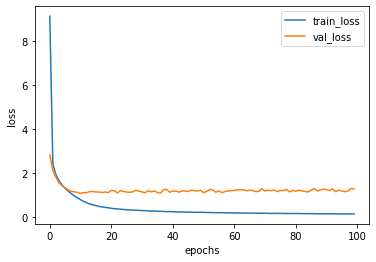

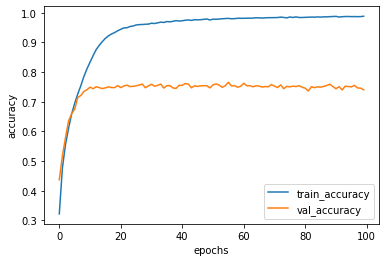

In [16]:
epochs = 100
# figure 1
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# figure 2
plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()